In [1]:
import os
import tensorflow as tf

tces_file = '../mnt/tess/astronet/tces-vetting-v02-include-centroiddist-train.csv'
file_pattern = '../mnt/tess/astronet/tfrecords-vetting-v02-include-centroiddist-train/*'
model_name = 'AstroCNNModelVetting'
config_name = 'base_new'
labels = ['p', 'e', 'n', 'j']
# tces_file = '../mnt/tess/astronet/tces-v14-test.csv'
# file_pattern = '../mnt/tess/astronet/tfrecords-38-test/*'
# model_name = 'AstroCNNModel'
# config_name = 'final_alpha_1'
# labels = ['E', 'N', 'J', 'S', 'B']

filenames = tf.io.gfile.glob(file_pattern)
    
filenames

2024-11-15 15:29:54.714322: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-15 15:30:15.526602: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


['../mnt/tess/astronet/tfrecords-vetting-v02-include-centroiddist-train/00001-of-00005',
 '../mnt/tess/astronet/tfrecords-vetting-v02-include-centroiddist-train/00000-of-00005',
 '../mnt/tess/astronet/tfrecords-vetting-v02-include-centroiddist-train/00004-of-00005',
 '../mnt/tess/astronet/tfrecords-vetting-v02-include-centroiddist-train/00003-of-00005',
 '../mnt/tess/astronet/tfrecords-vetting-v02-include-centroiddist-train/00002-of-00005']

In [2]:
import pandas as pd

tce_table = pd.read_csv(tces_file, header=0, low_memory=False)
print(len(tce_table))
tce_table.head(4)

6446


,Astro ID,TIC ID,Final,Decision,Distinct,mk,ch,et,md,as,...,File,comment,centroid_dist,disp_e,disp_p,disp_n,disp_b,disp_t,disp_u,disp_j
0,4493,58824746,pt,NaN,0,NaN,NaN,NaN,NaN,NaN,...,astronet_hlsp_qlp_tess_ffi-s0064-0000000058824...,TOI-4638.01 (PC) detected by QLP pipeline,5.312274,0,1,0,0,1,0,0
1,1494,404774891,et,NaN,1,et,et,et,NaN,et,...,mk_hlsp_qlp_tess_ffi-s0013-0000000404774891_te...,E labels from triage,1.032392,1,0,0,0,1,0,0
2,3070,336366871,eb,NaN,1,eb,eb,NaN,NaN,NaN,...,mk_hlsp_qlp_tess_ffi-s0011-0000000336366871_te...,EBs from TOI group vetting,19.409711,1,0,0,1,0,0,0
3,7483,310002617,pt,NaN,0,NaN,NaN,NaN,NaN,NaN,...,astronet_hlsp_qlp_tess_ffi-s0064-0000000310002...,TOI-4087.01 (PC) detected by QLP pipeline,0.450073,0,1,0,0,1,0,0


In [3]:
series = {}

for filename in filenames:
  tfr = tf.data.TFRecordDataset(filename)
  num_records = 0
  for record in tfr:
    num_records += 1
    ex = tf.train.Example.FromString(record.numpy())
    for k in ex.features.feature.keys():
      f = ex.features.feature[k]
      if f.int64_list.value:
        v = f.int64_list.value[0]
      elif f.float_list.value:
        v = f.float_list.value[0]
      elif f.bytes_list.value:
        v = f.bytes_list.value[0].decode()
      else:
        continue

      if k not in series:
        series[k] = []
      series[k].append(v)
  print(filename, num_records)

2024-11-15 15:31:33.396944: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46672 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:05:00.0, compute capability: 8.6
2024-11-15 15:31:33.399176: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46672 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:06:00.0, compute capability: 8.6
2024-11-15 15:31:33.400063: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 46672 MB memory:  -> device: 2, name: NVIDIA RTX A6000, pci bus id: 0000:45:00.0, compute capability: 8.6
2024-11-15 15:31:33.401127: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 46672 MB memory:  -> device: 3, name: NVIDIA RTX A6000, pci bus id: 0000:46:00.0, 

../mnt/tess/astronet/tfrecords-vetting-v02-include-centroiddist-train/00001-of-00005 1289


2024-11-15 15:31:35.219960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


../mnt/tess/astronet/tfrecords-vetting-v02-include-centroiddist-train/00000-of-00005 1289


2024-11-15 15:31:36.232724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


../mnt/tess/astronet/tfrecords-vetting-v02-include-centroiddist-train/00004-of-00005 1290


2024-11-15 15:31:37.555268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


../mnt/tess/astronet/tfrecords-vetting-v02-include-centroiddist-train/00003-of-00005 1289


2024-11-15 15:31:38.772151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


../mnt/tess/astronet/tfrecords-vetting-v02-include-centroiddist-train/00002-of-00005 1289


In [4]:
import pandas as pd

examples_table = pd.DataFrame.from_dict(series)

pd.set_option('display.max_columns', None)
# examples_table[['secondary_scale']].describe()
examples_table.describe()

,local_view,local_aperture_l,local_scale_present,secondary_std,local_scale_present_0.3,local_std,global_view_double_period,star_mass_present,local_std_even,global_view_half_period_0.3,local_view_half_period_0.3,local_mask,secondary_view_0.3,global_view_double_period_mask_0.3,global_view_double_period_mask,local_aperture_m_0.3,global_view_0.3,astro_id,local_std_odd,local_view_odd,global_view_double_period_std_0.3,disp_p,local_std_odd_0.3,global_view_half_period,star_rad,disp_b,disp_e,global_view_double_period_mask_5.0,secondary_scale_5.0,global_mask_5.0,local_aperture_l_5.0,local_mask_odd,global_view_half_period_std,local_mask_5.0,disp_u,star_rad_est,local_view_half_period_5.0,local_view_half_period_std_5.0,global_view_half_period_5.0,secondary_view_5.0,local_view_odd_5.0,local_std_even_5.0,local_view_even_5.0,local_view_even,global_transit_mask_5.0,global_view_half_period_mask_0.3,secondary_scale_present_0.3,global_transit_mask,local_view_even_0.3,local_aperture_l_0.3,n_points,global_mask_0.3,secondary_phase_5.0,secondary_scale_present_5.0,global_view_double_period_std,secondary_phase_0.3,local_scale_present_5.0,secondary_std_0.3,local_mask_0.3,local_std_even_0.3,secondary_mask_0.3,local_aperture_m_5.0,local_mask_even_0.3,global_std_5.0,local_mask_odd_5.0,global_view,secondary_scale_present,secondary_mask_5.0,local_std_0.3,secondary_mask,Period,sample_segments_view,secondary_std_5.0,local_view_half_period_std,global_view_half_period_std_0.3,local_view_half_period_mask_0.3,local_view_half_period_mask,sample_segments_local_view_5.0,local_view_0.3,n_folds,local_mask_odd_0.3,secondary_phase,star_rad_present,disp_n,global_view_5.0,star_rad_est_present,global_view_double_period_5.0,local_view_half_period_std_0.3,local_mask_even,sample_segments_local_view_0.3,local_scale_0.3,local_scale,local_view_half_period,global_view_double_period_std_5.0,Duration,global_view_half_period_mask,local_view_half_period_mask_5.0,sample_segments_view_0.3,local_aperture_s_5.0,local_std_odd_5.0,Tmag,local_std_5.0,secondary_scale,local_view_5.0,Transit_Depth,global_mask,star_mass,local_aperture_m,sample_segments_view_5.0,global_view_half_period_std_5.0,local_aperture_s,local_aperture_s_0.3,disp_t,global_std_0.3,global_std,sample_segments_local_view,local_view_odd_0.3,global_view_double_period_0.3,global_transit_mask_0.3,local_scale_5.0,secondary_view,global_view_half_period_mask_5.0,disp_j,local_mask_even_5.0,secondary_scale_0.3,centroid_dist
count,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6.446000e+03,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.0,6446.000000,6446.000000,6446.0,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.0,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.0,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.0,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.0,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6.446000e+03,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.0,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000,6446.000000
mean,0.043223,0.042866,0.999845,0.464904,0.997363,0.46442

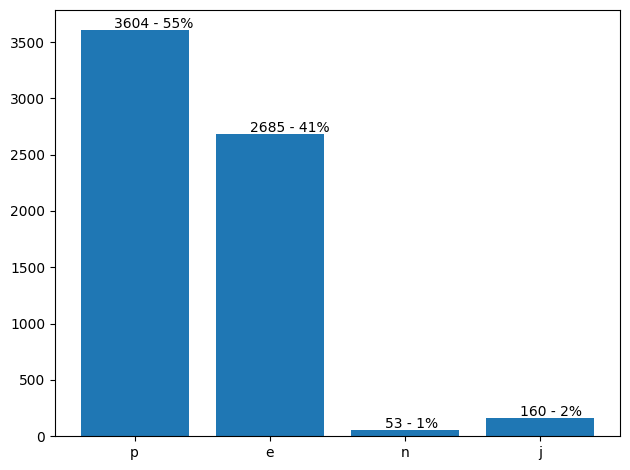

In [5]:
from matplotlib import pyplot as plt

counts = [sum(examples_table['disp_{}'.format(l)] > 0) for l in labels]
ax = plt.bar(labels, counts)
for i in range(len(labels)):
    b = ax[i]
    height = b.get_height()
    x, y = b.get_xy()
    plt.annotate(
        '{} - {:.0%}'.format(counts[i], counts[i] / sum(counts)),
        (x + 0.25, y + height + 20))
plt.tight_layout()


In [6]:
examples_table.head(3)

,local_view,local_aperture_l,local_scale_present,secondary_std,local_scale_present_0.3,local_std,global_view_double_period,star_mass_present,local_std_even,global_view_half_period_0.3,local_view_half_period_0.3,local_mask,secondary_view_0.3,global_view_double_period_mask_0.3,global_view_double_period_mask,local_aperture_m_0.3,global_view_0.3,astro_id,local_std_odd,local_view_odd,global_view_double_period_std_0.3,disp_p,local_std_odd_0.3,global_view_half_period,star_rad,disp_b,disp_e,global_view_double_period_mask_5.0,secondary_scale_5.0,global_mask_5.0,local_aperture_l_5.0,local_mask_odd,global_view_half_period_std,local_mask_5.0,disp_u,star_rad_est,local_view_half_period_5.0,local_view_half_period_std_5.0,global_view_half_period_5.0,secondary_view_5.0,local_view_odd_5.0,local_std_even_5.0,local_view_even_5.0,local_view_even,global_transit_mask_5.0,global_view_half_period_mask_0.3,secondary_scale_present_0.3,global_transit_mask,local_view_even_0.3,local_aperture_l_0.3,n_points,global_mask_0.3,secondary_phase_5.0,secondary_scale_present_5.0,global_view_double_period_std,secondary_phase_0.3,local_scale_present_5.0,secondary_std_0.3,local_mask_0.3,local_std_even_0.3,secondary_mask_0.3,local_aperture_m_5.0,local_mask_even_0.3,global_std_5.0,local_mask_odd_5.0,global_view,secondary_scale_present,secondary_mask_5.0,local_std_0.3,secondary_mask,Period,sample_segments_view,secondary_std_5.0,local_view_half_period_std,global_view_half_period_std_0.3,local_view_half_period_mask_0.3,local_view_half_period_mask,sample_segments_local_view_5.0,local_view_0.3,n_folds,local_mask_odd_0.3,secondary_phase,star_rad_present,disp_n,global_view_5.0,star_rad_est_present,global_view_double_period_5.0,local_view_half_period_std_0.3,local_mask_even,sample_segments_local_view_0.3,local_scale_0.3,local_scale,local_view_half_period,global_view_double_period_std_5.0,Duration,global_view_half_period_mask,local_view_half_period_mask_5.0,sample_segments_view_0.3,local_aperture_s_5.0,local_std_odd_5.0,Tmag,local_std_5.0,secondary_scale,local_view_5.0,Transit_Depth,global_mask,star_mass,local_aperture_m,sample_segments_view_5.0,global_view_half_period_std_5.0,local_aperture_s,local_aperture_s_0.3,disp_t,global_std_0.3,global_std,sample_segments_local_view,local_view_odd_0.3,global_view_double_period_0.3,global_transit_mask_0.3,local_scale_5.0,secondary_view,global_view_half_period_mask_5.0,disp_j,local_mask_even_5.0,secondary_scale_0.3,centroid_dist
0,-0.138952,-0.151997,1.0,0.459228,1.0,0.405227,-0.085958,1.0,0.447998,0.443360,0.429711,1.0,-0.136514,1.0,1.0,-0.052991,-0.052329,3485,0.356763,-0.148876,0.203722,0,0.236584,0.479578,1.452970,0,0,1.0,0.006689,1.0,-0.158606,1.0,0.770429,1.0,0,1.402871,0.478801,0.910291,0.469048,-0.197316,-0.096295,0.513875,-0.170791,-0.128605,0.0,1.0,1.0,0.0,-0.063534,-0.033376,813.0,1.0,0.441888,1.0,0.135243,0.490902,1.0,0.406768,1.0,0.314966,1.0,-0.132765,1.0,0.495050,1.0,-0.134251,1.0,1.0,0.280614,1.0,0.690294,0.996466,0.366652,0.685160,0.606783,1.0,1.0,0.999484,-0.052991,58.0,1.0,0.466395,1.0,0,-0.102004,1.0,-0.071410,0.612546,1.0,1.001814,0.028817,0.022799,0.435374,0.499561,0.169170,1.0,1.0,1.001708,-0.125981,0.374371,10.6608,0.456692,0.005417,-0.132765,24138.539062,1.0,1.32,-0.138952,0.999067,0.935528,-0.138001,-0.052324,0,0.280508,0.402010,0.996531,-0.042880,0.050313,0.0,0.024044,-0.191695,1.0,1,1.0,0.005638,0.542673
1,-0.148708,-0.173233,1.0,0.634052,1.0,0.611006,0.254419,1.0,0.664889,-0.182621,-0.149064,1.0,-0.000830,1.0,1.0,-0.056963,0.240807,7785,0.550819,-0.078549,0.944652,1,0.540192,-0.168576,0.991556,0,0,1.0,0.000100,1.0,-0.179406,1.0,1.522972,1.0,0,0.000000,-0.172546,1.394290,-0.105523,-0.019340,-0.074579,0.686276,-0.262737,-0.232448,0.0,1.0,1.0,0.0,-0.307735,-0.104685,6090.0,1.0,0.176191,1.0,0.895079,0.666247,1.0,0.637179,1.0,0.768218,1.0,-0.160357,1.0,0.723717,1.0,0.247191,1.0,1.0,0.567693,1.0,2.695583,1.000103,0.570414,1.429835,1.539563,1.0,1.0,1.000167,-0.056963,37.0,1.0,0.420100,1.0,0,0.171224,0.0,0.153646,1.42548

In [7]:
tce_table[tce_table.index == 8209]

,Astro ID,TIC ID,Final,Decision,Distinct,mk,ch,et,md,as,dm,Tansu,Shishir,Astronet note,"Seed randbetween(1, 100)",Split,RA,Dec,Tmag,Epoc,Per,Dur,Depth,Sectors,SRad,SMass,teff,logg,SN,Qingress,SRadEst,File,comment,centroid_dist,disp_e,disp_p,disp_n,disp_b,disp_t,disp_u,disp_j


In [8]:
import numpy as np

print('Label mismtaches between TCE and tfrecords:')
np.array(set(tce_table[tce_table[f'disp_{labels[0]}'] > 0]['Astro ID'].values)
    - set(examples_table[examples_table[f'disp_{labels[0]}'] > 0]['astro_id'].values))

Label mismtaches between TCE and tfrecords:


array(set(), dtype=object)

In [9]:
import tensorflow as tf

from astronet import models
from astronet.astro_cnn_model import input_ds

config = models.get_model_config(model_name, config_name)

ds = input_ds.build_dataset(
      file_pattern=file_pattern,
      input_config=config.inputs,
      batch_size=1,
      include_labels=False,
      shuffle_filenames=False,
      repeat=1,
      include_identifiers=True)
labels_ds = input_ds.build_dataset(
      file_pattern=file_pattern,
      input_config=config.inputs,
      batch_size=1,
      include_labels=True,
      shuffle_filenames=False,
      repeat=1,
      include_identifiers=True)
labels_iter = iter(labels_ds)

label_index = {k.lower(): i for i, k in enumerate(config.inputs.label_columns)}
cols = [f"disp_{l}" for l in labels]  # ["disp_E", "disp_N", "disp_J", "disp_S", "disp_B"]


all_ids = []
bad_labels = []
for d in ds:
  lab = next(labels_iter)
  
  def lam(e):
    if e.dtype == tf.int64:
        return e
    if tf.reduce_any(tf.math.is_nan(e)):
        tf.print(e, summarize=-1)
        raise ValueError('data has NaNs.')
    return e
  ex_id = d[1].numpy().item()
  all_ids.append(ex_id)
  
  assert lab[0]['duration'] == d[0]['duration']
  rec = tce_table[tce_table['Astro ID'] == ex_id]
  for c in cols:
    if (lab[1][0][label_index[c.lower()]].numpy() == 0) != (rec[c].values[0] == 0):
      bad_labels.append(ex_id)
      print('bad example: ', ex_id)
      print(rec)
      print(cols)
      print(lab[1][0])
      break
  if bad_labels:
    break
  
  try:
    tf.nest.map_structure(lam, d)
  except ValueError as e:
    print(e)
    print(d[1])
    break
else:
  print('No NaNs or mismtached labels found.')

if len(all_ids) == len(set(all_ids)):
  print('No duplicates found.')
else:
  print('Found duplicates!', len(all_ids) - len(set(all_ids)))
  print([t for t in set(all_ids) if all_ids.count(t) > 1])

2024-11-15 15:31:42.448893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5]
	 [[{{node Placeholder/_0}}]]
2024-11-15 15:31:42.601414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5]
	 [[{{node Placeholder/_0}}]]


No NaNs or mismtached labels found.
No duplicates found.


In [10]:
def astro_id(tic_id):
  return tce_table[tce_table['TIC ID'] == tic_id]['Astro ID'].values[0]

In [11]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from astronet.preprocess import preprocess


tess_data_dir = '../mnt/tess/lc'

def find_tce(astro_id):
  with tf.device('cpu'):
    for filename in filenames:
      tfr = tf.data.TFRecordDataset(filename)
      for record in tfr:
        ex = tf.train.Example.FromString(record.numpy())
        if (ex.features.feature["astro_id"].int64_list.value[0] == astro_id):
          print('TIC ID:', tic_id)
          for l in labels:
              print(f'{l}:', ex.features.feature[f"disp_{l}"].int64_list.value[0])
          print('Duration:', ex.features.feature["Duration"].float_list.value[0])
          return ex

    raise ValueError("{} not found in files: {}".format(astro_id, filenames))

In [12]:
ds = ds.cache()
def plot_ds_tce(ds, astro_id):
    for d in ds:
        if d[1] == astro_id:
            for k, v in d[0].items():
                if k.startswith('local_'):
                    continue
                if k.startswith('global_'):
                    continue
                if k.startswith('secondary_'):
                    continue
                if k.startswith('sample_'):
                    continue
                print(f'{k:25}: {v.numpy()}')
            global_view = np.array(d[0]['global_view'][0].numpy())
            local_view = np.array(d[0]['local_view'][0].numpy())
            secondary_view = np.array(d[0]['secondary_view'][0].numpy())
            fig, axes = plt.subplots(2, 3, figsize=(20, 12))
            axes[0, 0].plot(global_view, '.-')
            axes[0, 1].plot(local_view, '.-')
            axes[0, 2].plot(secondary_view, '.-')
            axes[1, 0].plot(d[0]['global_mask'][0].numpy(), '.-')
            axes[1, 1].plot(d[0]['global_view_0.3'][0].numpy(), '.-')
            axes[1, 2].plot(d[0]['global_view_5.0'][0].numpy(), '.-')
            plt.show()
            plt.close('all')
            return

In [13]:
ds

<CacheDataset element_spec=({'duration': TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), 'period': TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), 'tmag': TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), 'transit_depth': TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), 'global_mask': TensorSpec(shape=(None, 201), dtype=tf.float32, name=None), 'global_std': TensorSpec(shape=(None, 201), dtype=tf.float32, name=None), 'global_transit_mask': TensorSpec(shape=(None, 201), dtype=tf.float32, name=None), 'global_view': TensorSpec(shape=(None, 201), dtype=tf.float32, name=None), 'global_view_0.3': TensorSpec(shape=(None, 201), dtype=tf.float32, name=None), 'global_view_5.0': TensorSpec(shape=(None, 201), dtype=tf.float32, name=None), 'global_view_double_period': TensorSpec(shape=(None, 201), dtype=tf.float32, name=None), 'global_view_double_period_0.3': TensorSpec(shape=(None, 201), dtype=tf.float32, name=None), 'global_view_double_period_5.0': TensorSpec(s

2024-11-15 15:33:52.065930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5]
	 [[{{node Placeholder/_0}}]]


duration                 : [[-0.03010806]]
period                   : [[0.21632543]]
tmag                     : [[0.7161043]]
transit_depth            : [[0.2314925]]
n_folds                  : [[0.75925696]]
star_mass                : [[0.29319498]]
star_mass_present        : [[1.]]
star_rad                 : [[-0.56831986]]
star_rad_est             : [[-0.22630557]]
star_rad_est_present     : [[1.]]
star_rad_present         : [[1.]]


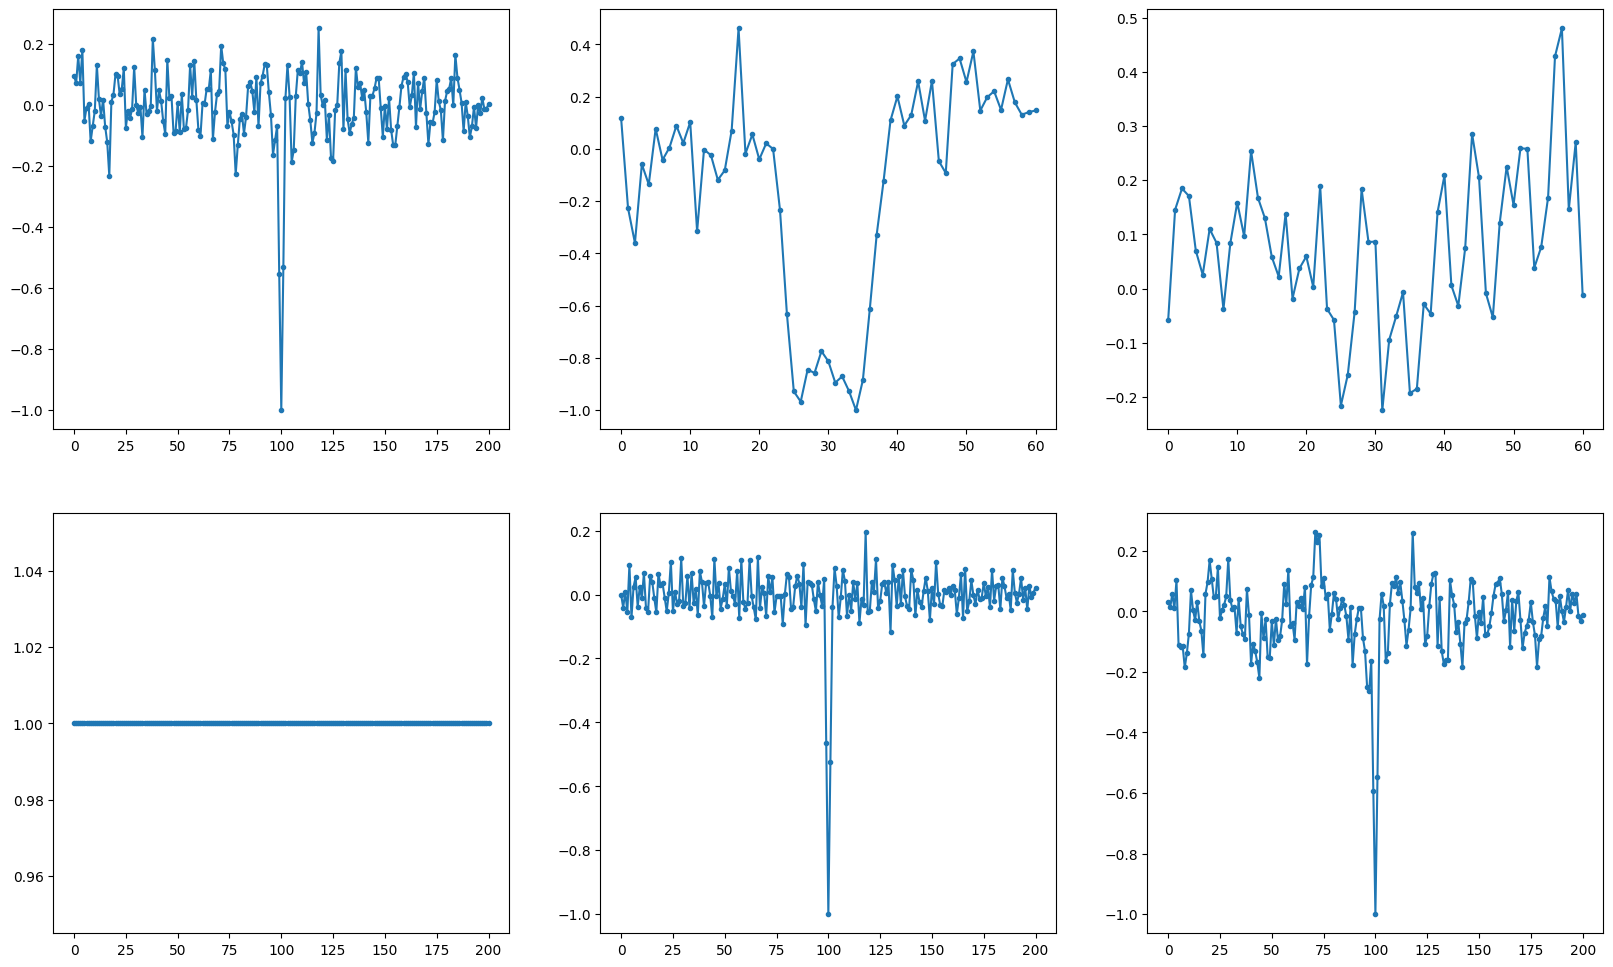

2024-11-15 15:33:53.905027: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [14]:
tic_id = 314865962
plot_ds_tce(ds, astro_id(tic_id))

In [26]:
tce_table[tce_table['TIC ID'] == tic_id]

,Astro ID,TIC ID,Final,Decision,Distinct,mk,ch,et,md,as,dm,Tansu,Shishir,Astronet note,"Seed randbetween(1, 100)",Split,RA,Dec,Tmag,Epoc,Per,Dur,Depth,Sectors,SRad,SMass,teff,logg,SN,Qingress,SRadEst,File,comment,centroid_dist,disp_e,disp_p,disp_n,disp_b,disp_t,disp_u,disp_j
2264,1069,314865962,pt,pt,2,pt,pu,pt,pt,pt,NaN,NaN,NaN,NaN,11.0,val,53.281311,-72.744243,10.3539,1335.941311,22.463614,0.24098,480.616966,NaN,0.978381,0.98,5548.0,4.44828,NaN,NaN,0.970018,mk_hlsp_qlp_tess_ffi-s0033-0000000314865962_te...,E labels from triage,0.392701,0,1,0,0,1,0,0


In [27]:
astro_id(tic_id)

1069

In [28]:
examples_table[examples_table['astro_id'] == astro_id(tic_id)]

,local_view,local_aperture_l,local_scale_present,secondary_std,local_scale_present_0.3,local_std,global_view_double_period,star_mass_present,local_std_even,global_view_half_period_0.3,local_view_half_period_0.3,local_mask,secondary_view_0.3,global_view_double_period_mask_0.3,global_view_double_period_mask,local_aperture_m_0.3,global_view_0.3,astro_id,local_std_odd,local_view_odd,global_view_double_period_std_0.3,disp_p,local_std_odd_0.3,global_view_half_period,star_rad,disp_b,disp_e,global_view_double_period_mask_5.0,secondary_scale_5.0,global_mask_5.0,local_aperture_l_5.0,local_mask_odd,global_view_half_period_std,local_mask_5.0,disp_u,star_rad_est,local_view_half_period_5.0,local_view_half_period_std_5.0,global_view_half_period_5.0,secondary_view_5.0,local_view_odd_5.0,local_std_even_5.0,local_view_even_5.0,local_view_even,global_transit_mask_5.0,global_view_half_period_mask_0.3,secondary_scale_present_0.3,global_transit_mask,local_view_even_0.3,local_aperture_l_0.3,n_points,global_mask_0.3,secondary_phase_5.0,secondary_scale_present_5.0,global_view_double_period_std,secondary_phase_0.3,local_scale_present_5.0,secondary_std_0.3,local_mask_0.3,local_std_even_0.3,secondary_mask_0.3,local_aperture_m_5.0,local_mask_even_0.3,global_std_5.0,local_mask_odd_5.0,global_view,secondary_scale_present,secondary_mask_5.0,local_std_0.3,secondary_mask,Period,sample_segments_view,secondary_std_5.0,local_view_half_period_std,global_view_half_period_std_0.3,local_view_half_period_mask_0.3,local_view_half_period_mask,sample_segments_local_view_5.0,local_view_0.3,n_folds,local_mask_odd_0.3,secondary_phase,star_rad_present,disp_n,global_view_5.0,star_rad_est_present,global_view_double_period_5.0,local_view_half_period_std_0.3,local_mask_even,sample_segments_local_view_0.3,local_scale_0.3,local_scale,local_view_half_period,global_view_double_period_std_5.0,Duration,global_view_half_period_mask,local_view_half_period_mask_5.0,sample_segments_view_0.3,local_aperture_s_5.0,local_std_odd_5.0,Tmag,local_std_5.0,secondary_scale,local_view_5.0,Transit_Depth,global_mask,star_mass,local_aperture_m,sample_segments_view_5.0,global_view_half_period_std_5.0,local_aperture_s,local_aperture_s_0.3,disp_t,global_std_0.3,global_std,sample_segments_local_view,local_view_odd_0.3,global_view_double_period_0.3,global_transit_mask_0.3,local_scale_5.0,secondary_view,global_view_half_period_mask_5.0,disp_j,local_mask_even_5.0,secondary_scale_0.3,centroid_dist
975,0.11708,0.145571,1.0,0.623956,1.0,0.697678,-0.018083,1.0,0.673137,-0.074104,0.231539,1.0,-0.016642,1.0,1.0,0.140545,0.0,1069,0.71745,0.0738,0.843457,1,0.522347,-0.100192,0.978381,0,0,1.0,0.000203,1.0,0.147605,1.0,1.480818,1.0,0,0.970018,0.168411,1.396614,-0.069715,0.112919,0.196665,0.713158,0.070067,0.167545,0.0,1.0,1.0,0.0,0.275157,0.18598,21607.0,1.0,0.864885,1.0,0.868297,0.819829,1.0,0.510658,1.0,0.551581,1.0,0.138218,1.0,0.709372,1.0,0.096146,1.0,1.0,0.547717,1.0,22.463614,0.999961,0.989926,1.309888,1.385268,1.0,1.0,1.000505,0.140545,32.0,1.0,0.583822,1.0,0,0.029915,1.0,-0.181992,1.134928,1.0,1.000474,0.000912,0.000744,0.102603,0.743763,0.24098,1.0,1.0,1.000014,0.133496,0.769912,10.3539,0.749103,0.000224,0.138218,480.616974,1.0,0.98,0.11708,1.000291,1.426843,0.123759,0.118504,1,0.674287,0.748839,1.000381,0.025102,-0.05435,0.0,0.000725,-0.058025,1.0,0,1.0,0.000207,0.392701


In [29]:
!ls ../mnt/tess/lc | grep 322117652

mk_hlsp_qlp_tess_ffi-s0011-0000000322117652_tess_v01_llc.fits


In [30]:
tic_id = 314865962
tce = find_tce(astro_id(tic_id))

list(tce.features.feature.keys())

2024-08-29 12:33:48.142092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


TIC ID: 314865962
p: 1
e: 0
n: 0
j: 0
Duration: 0.24098041653633118


['local_view',
 'local_aperture_l',
 'local_scale_present',
 'secondary_std',
 'local_scale_present_0.3',
 'local_std',
 'global_view_double_period',
 'star_mass_present',
 'local_std_even',
 'global_view_half_period_0.3',
 'local_view_half_period_0.3',
 'local_mask',
 'secondary_view_0.3',
 'global_view_double_period_mask_0.3',
 'global_view_double_period_mask',
 'local_aperture_m_0.3',
 'global_view_0.3',
 'astro_id',
 'local_std_odd',
 'local_view_odd',
 'global_view_double_period_std_0.3',
 'disp_p',
 'local_std_odd_0.3',
 'global_view_half_period',
 'star_rad',
 'disp_b',
 'disp_e',
 'global_view_double_period_mask_5.0',
 'secondary_scale_5.0',
 'global_mask_5.0',
 'local_aperture_l_5.0',
 'local_mask_odd',
 'global_view_half_period_std',
 'local_mask_5.0',
 'disp_u',
 'star_rad_est',
 'local_view_half_period_5.0',
 'local_view_half_period_std_5.0',
 'global_view_half_period_5.0',
 'secondary_view_5.0',
 'local_view_odd_5.0',
 'local_std_even_5.0',
 'local_view_even_5.0',
 'local_